# Wolff cluster algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class IsingSimulation:

    J = 6.34369e-21  # Interaction constant for iron [Joule]
    kB = 1.38065e-23  # Boltzmann constant [Joule / Kelvin]

    def __init__(self, size, temperature=300):
        '''
        Create a new Ising model simulation. The state is initialized
        randomly.

        Arguments:

            size (int) The number of cells along each dimension of the
              square grid.

            temperature (float) The temperature in Kelvin at which to
              run the simulation. The Curie temperature for iron is
              1043 K. Room temperature is about 300 K. Default: 300.
        '''
        self.size = size
        self.set_temperature(temperature)
        self.state = np.random.choice(
            [-1, +1], size=(self.size, self.size))
        self.step = 0
        self.total_flips = 0

    def set_temperature(self, temp):
        '''
        Set the temperature of the model in Kelvin.
        '''
        self.temperature = float(temp)
        self.cluster_prob = 1 - np.exp(-2 * self.J / (self.temperature * self.kB))

    def energy(self):
        '''
        Compute the energy of the current state of the model.
        '''
        return -self.J * (self.state * (
            np.roll(self.state, 1, axis=0) +
            np.roll(self.state, 1, axis=1))).sum()

    def average_magnetism(self):
        '''
        Compute the average per-cell magnetism of the current state
        of the model.
        '''
        return self.state.mean()

    def update(self):
        '''
        Do a single cluster update of the model state.
        '''
        # Pick a random cell to start the cluster
        i, j = np.random.randint(self.size, size=2)
        cell_value = self.state[i, j]
        cluster = {(i, j)}
        pocket = [(i, j)]

        while len(pocket) > 0:
            # Get a random cell from the pocket
            i, j = pocket.pop(np.random.randint(0, len(pocket)))
            # Check whether to add any of the cell's neighbors to the cluster
            for u, v in [
                ((i - 1) % self.size, j),
                ((i + 1) % self.size, j),
                (i, (j - 1) % self.size),
                (i, (j + 1) % self.size)
            ]:
                if (
                    (self.state[u, v] == cell_value) and
                    ((u, v) not in cluster) and
                    (np.random.uniform(0, 1) < self.cluster_prob)
                ):
                    pocket.append((u, v))
                    cluster.add((u, v))
        # Flip all cells in the cluster
        for (i, j) in cluster:
            self.state[i, j] = -cell_value
        self.step += 1
        self.total_flips += len(cluster)

    def display(self):
        '''
        Plot the state of the model.
        '''
        plt.imshow(self.state, vmin=-1, vmax=+1)
        plt.title('Updates: ' + str(self.step) + '. Flips: ' +\
                   str(self.total_flips) + '. M = ' + str(self.average_magnetism()))

Temperature: 1043 K


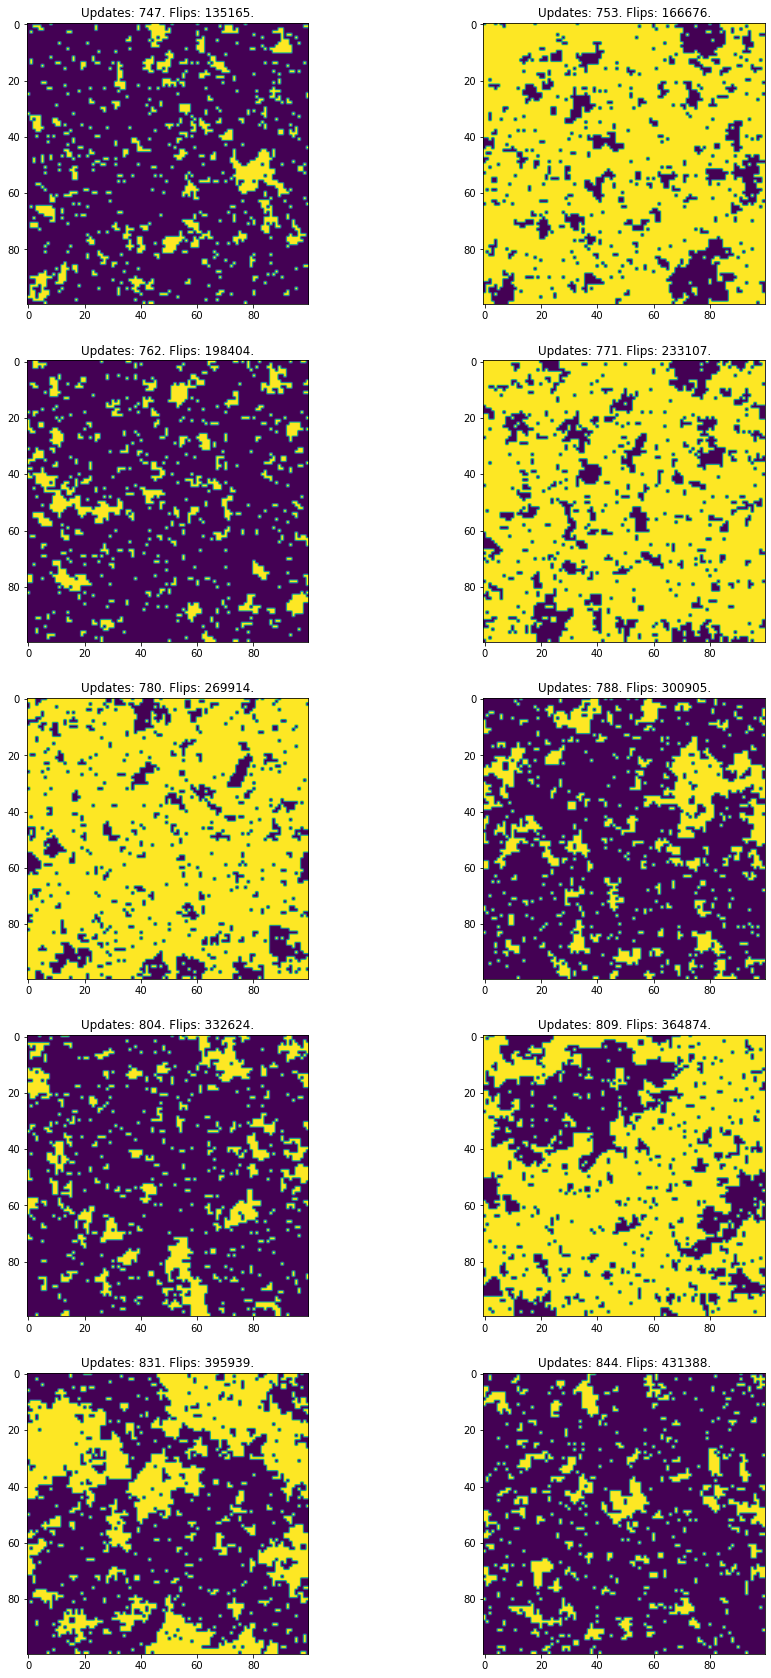

In [5]:
# Create a simulation at the critical temperature

size = 100
temperature = 1043
burn_in_passes = 10  # A single pass is defined as flipping each cell in the grid once, on average.
passes_between_samples = 3
number_of_samples = 10

print('Temperature: ' + str(temperature) + ' K')
sim = IsingSimulation(size, temperature)

# Burn-in phase
while sim.total_flips < burn_in_passes * size**2:
    sim.update()

# Generate a few samples
plt.figure(figsize=(15, 30))
for _ in range(number_of_samples):
    start = sim.total_flips
    stop = start + passes_between_samples * size**2
    while sim.total_flips < stop:
        sim.update()
    plt.subplot(5, 2, _+1)
    sim.display()
    plt.title('Updates: ' + str(sim.step) + '. Flips: ' + str(sim.total_flips) + '.')

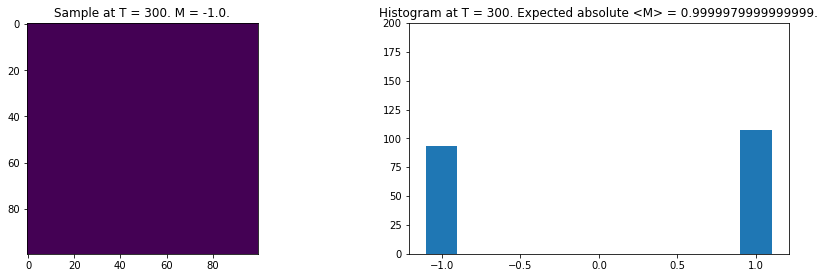

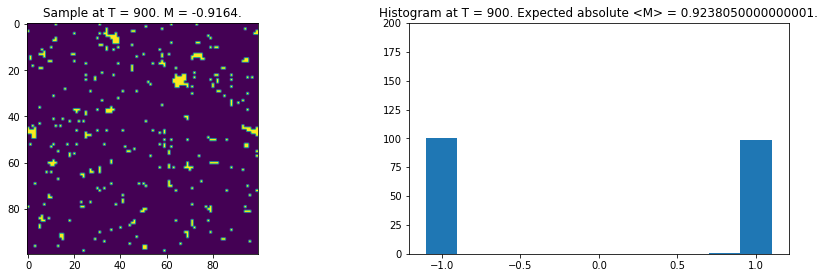

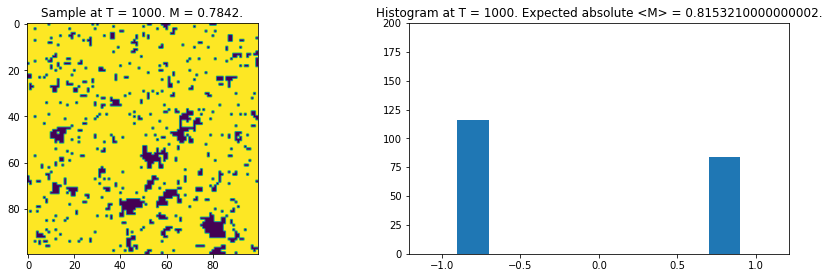

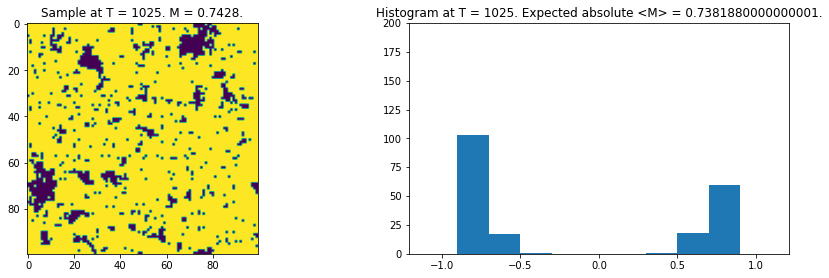

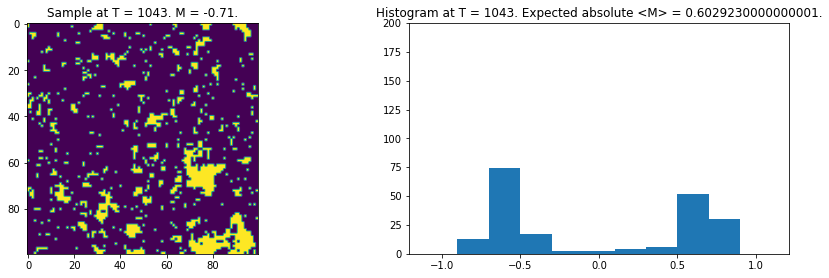

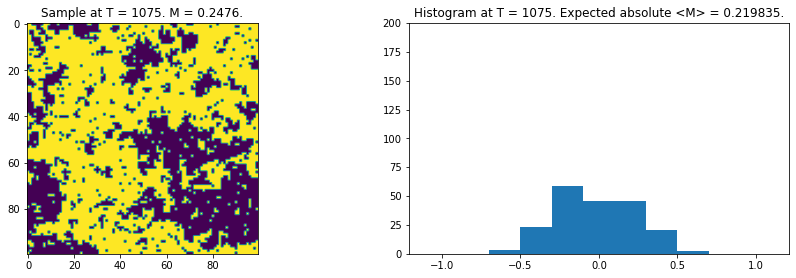

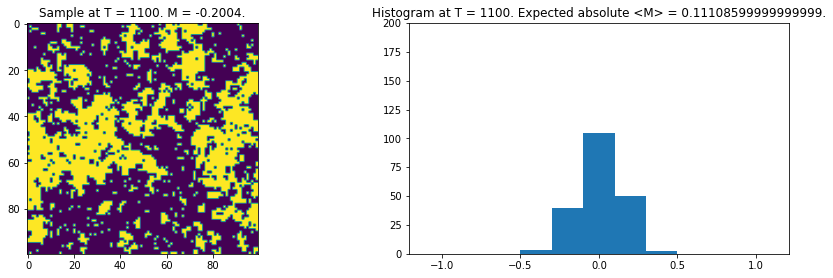

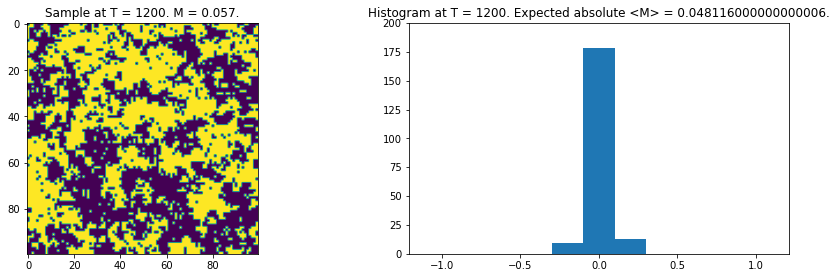

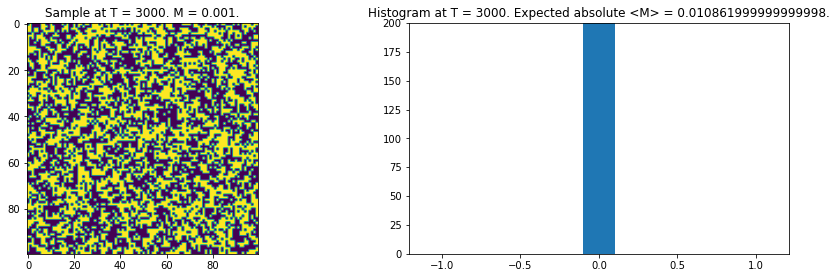

In [6]:
# NOTE: This cell takes about 15 minutes to run

size = 100
number_of_samples = 200
burn_in_passes = 10
passes_between_samples = 3
count = 0

for temperature in [300, 900, 1000, 1025, 1043, 1075, 1100, 1200, 3000]:
    sim = IsingSimulation(size, temperature)
    while sim.total_flips < burn_in_passes * size**2:
        sim.update()
    average_magnetism = []
    for _ in range(number_of_samples):
        start = sim.total_flips
        stop = start + (passes_between_samples + np.random.randint(2)) * size**2
        while sim.total_flips < stop:
            sim.update()
        average_magnetism.append(sim.average_magnetism())
    plt.figure(figsize=(15, 45))
    count+=1
    plt.subplot(9, 2, count)
    sim.display()
    plt.title(
        'Sample at T = ' + str(temperature) +
        '. M = ' + str(sim.average_magnetism()) + '.')
    count+=1
    plt.subplot(9, 2, count)
    plt.hist(average_magnetism, range=[-1.1, 1.1], bins=11)
    plt.ylim(0, number_of_samples)
    plt.title(
        'Histogram at T = ' + str(temperature) +
        '. Expected absolute <M> = ' + str(np.mean(np.fabs(average_magnetism))) + '.')
plt.show()

### Expected absolute mean magnetization as a function of temperature

In [7]:
# NOTE: This cell takes about 10 minutes to run

size = 100
temperatures = np.linspace(300, 1500, 13)
burn_in_passes = 10
passes_between_samples = 3
samples = 100

results = []
for i in range(len(temperatures)):
    sim = IsingSimulation(size, temperatures[i])
    while sim.total_flips < burn_in_passes * size**2:
        sim.update()
    m_samples = []
    for _ in range(samples):
        start = sim.total_flips
        stop = start + passes_between_samples * size**2
        while sim.total_flips < stop:
            sim.update()
        m_samples.append(abs(sim.average_magnetism()))
    results.append(np.mean(m_samples))

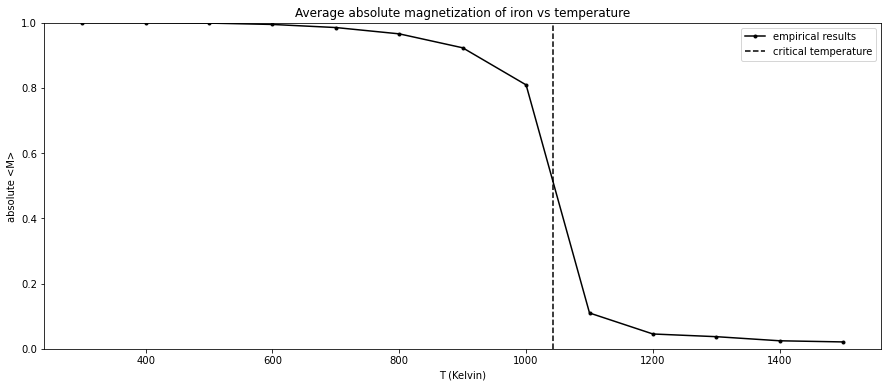

In [9]:
plt.figure(figsize=(15,6))
plt.plot(temperatures, results, 'k.-', label='empirical results')
plt.axvline(1043, color='k', linestyle='--', label='critical temperature')
plt.ylim(0, 1)
plt.title('Average absolute magnetization of iron vs temperature')
plt.xlabel('T (Kelvin)')
plt.ylabel('absolute <M>')
plt.legend()
plt.show()